<a href="https://colab.research.google.com/github/Koosmaster/Tutorial-Automatic-Modulation-Classification/blob/main/Draft_AMC_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial: RF Signal Classification Using Deep Learning Models for Modulation Recognition

**by Markus Parrish**  
*updated: 2025-09-27*

---

## Project Overview
This tutorial demonstrates the development and evaluation of machine learning models for the identification of radio frequency (RF) signals through Automatic Modulation Classification (AMC).  

- **Baseline Models:** k-Nearest Neighbors (kNN), Support Vector Machines (SVM), Random Forests  
- **Deep Learning Models:** Convolutional Neural Networks (CNN), Recurrent Neural Networks (RNN), and Hybrid CNN+RNN  
- **Dataset:** RadioML 2016.10A  
- **Objective:** Compare performance across varying Signal-to-Noise Ratio (SNR) levels and highlight the benefits and limitations of each method.  



---

## Setup
Steps to prepare the Colab environment:
1. Enable GPU acceleration  
2. Import required libraries (NumPy, Pandas, Matplotlib, Seaborn, h5py, scikit-learn, PyTorch)  
3. Mount Google Drive or upload the dataset  
4. Verify imports and environment  

---


In [23]:
# For access to datasets saved on google drive
from google.colab import drive
drive.mount('/content/drive') ## Change this to where datasets are saved

# Libraries
## Code below from haozheng61
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pickle
import os

## CNN tutorial radioml2016 - mattias g cross
import pandas as pd
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Reshape, Conv2D, MaxPool2D, ZeroPadding2D, Dense, Dropout, Activation, Flatten, GaussianNoise

## KNN - AHMEDALI30
import seaborn as sns
from scipy.signal import welch
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import warnings
import time # Import time module for complexity measurement


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



## Dataset
- **Source:** RadioML 2016.10A (DeepSig)  
- **Format:** Pickle file (`.pkl`) containing I/Q signal samples  
- **Classes:** 11 modulation types (8 digital, 3 analog)  
- **SNR Range:** –20 dB to +18 dB (2 dB steps)  
- **Samples:** Each record has 128 complex I/Q samples  

---



## Data Exploration
Goals:
- Inspect dataset structure  
- Plot example I/Q waveforms  
- Visualize modulation class distribution  
- (Optional) Plot spectrograms and constellation diagrams  

---



## Preprocessing
Steps:
- Split into Train / Validation / Test sets (e.g., 70/15/15)  
- Normalize or standardize data  
- Prepare input shapes:  
  - **Classical ML:** Flattened vectors (N × 256)  
  - **CNN:** (N × 2 × 128)  
  - **RNN:** (N × 128 × 2)  
- Encode labels into numeric classes  

---


In [3]:
## source: https://www.kaggle.com/code/mattiasgcross/cnn-tutorial-for-radioml2016#Create-the-convolutional-base
with open('/content/drive/MyDrive/AMC_matlab_dataset.pkl', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    p = u.load()


## Baseline Models (kNN, SVM, Random Forest)
- Train and evaluate classical ML models  
- Measure accuracy, confusion matrices  
- Use as a benchmark against deep learning models  

---



## CNN Model
- Implement 1D CNN architecture in PyTorch  
- Train with cross-entropy loss and Adam optimizer  
- Track accuracy/loss curves over epochs  
- Evaluate on test set and visualize confusion matrix  
SOURCE: https://www.kaggle.com/code/mattiasgcross/cnn-tutorial-for-radioml2016#Create-the-convolutional-base
---



In [9]:
## source: https://www.kaggle.com/code/mattiasgcross/cnn-tutorial-for-radioml2016#Create-the-convolutional-base
snrs, mods = map(lambda j: sorted(list(set(map(lambda x: x[j], p.keys())))), [1,0])


X = []
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(p[(mod,snr)])
        for i in range(p[(mod,snr)].shape[0]):  lbl.append((mod,snr))


X = np.vstack(X)

# Partition the data
#  into training and test sets of the form we can train/test on
#  while keeping SNR and Mod labels handy for each
np.random.seed(2016)
n_examples = int(X.shape[0])
n_train = int(n_examples * 0.5)
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]

def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1

print(lbl[0][0])
Y_train = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), train_idx)))
Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))

## Verify
in_shp = list(X_train.shape[1:])
print(X_train.shape, in_shp)
classes = mods



b'16QAM'
(5500, 2, 256) [2, 256]


In [10]:
classes


[b'16QAM',
 b'64QAM',
 b'8PSK',
 b'B-FM',
 b'BPSK',
 b'CPFSK',
 b'DSB-AM',
 b'GFSK',
 b'PAM4',
 b'QPSK',
 b'SSB-AM']

In [11]:
snrs

[-6, -2, 2, 6, 10, 14, 18, 22, 26, 30]

Class num:  3
Class name:  b'B-FM'


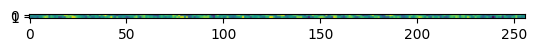

Class num:  3
Class name:  b'B-FM'


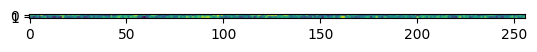

Class num:  7
Class name:  b'GFSK'


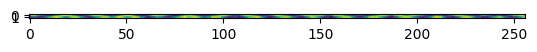

Class num:  8
Class name:  b'PAM4'


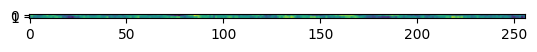

Class num:  4
Class name:  b'BPSK'


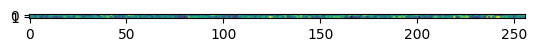

In [12]:
for i in range(5):
    print('Class num: ', np.argmax(Y_train[i]))
    print('Class name: ', classes[np.argmax(Y_train[i])])
    plt.imshow(X_train[i])
    plt.show()


In [13]:
# Build VT-CNN2 Neural Net model using Keras primitives --
#  - Reshape [N,2,128] to [N,1,2,128] on input
#  - Pass through 2 2DConv/ReLu layers
#  - Pass through 2 Dense layers (ReLu and Softmax)
#  - Perform categorical cross entropy optimization

dr = 0.5 # dropout rate (%)
model = models.Sequential()
model.add(Reshape(in_shp + [1], input_shape=in_shp))

# convolutional layers

model.add(ZeroPadding2D((0, 1)))
model.add(Conv2D(1, (1, 3), activation="relu"))


# exercise: add more conv and padding layers. Maybe even max pooling? (and dropout)

# model.add(Conv2D(256, (1, 3), activation="relu"))
# model.add(Dropout(dr))
# model.add(ZeroPadding2D((0, 2)))
# model.add(Conv2D(80, (2, 3), activation="relu"))
# model.add(Dropout(dr))

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 2, 256, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, 2, 258, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 2, 256, 1)      │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4 (16.00 B)

 Trainable params: 4 (16.00 B)

 Non-trainable params: 0 (0.00 B)

In [14]:
# dense layers
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(dr))
model.add(Dense(len(classes)))
model.add(Activation('softmax'))
model.add(Reshape([len(classes)]))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 2, 256, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, 2, 258, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 2, 256, 1)      │             4 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │         2,827 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 11)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 11)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,159 (524.06 KB)

 Trainable params: 134,159 (524.06 KB)

 Non-trainable params: 0 (0.00 B)

Text(0.5, 1.0, 'ReLU')

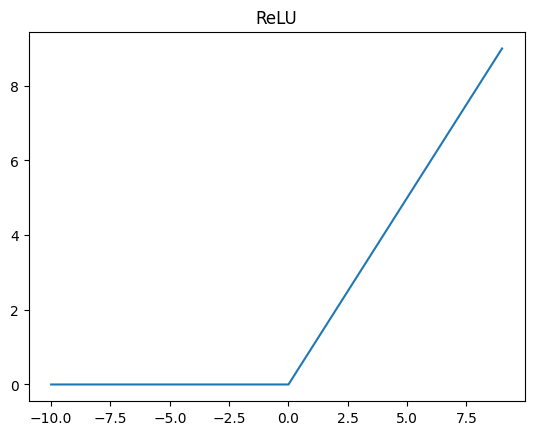

In [15]:
def ReLU(x):
    """Readable ReLU activation function"""
    if x < 0:
        return 0
    else:
        return x
plt.plot(np.arange(-10, 10), [ReLU(x) for x in np.arange(-10, 10)])
plt.title('ReLU')

Text(0.5, 1.0, 'Sigmoid')

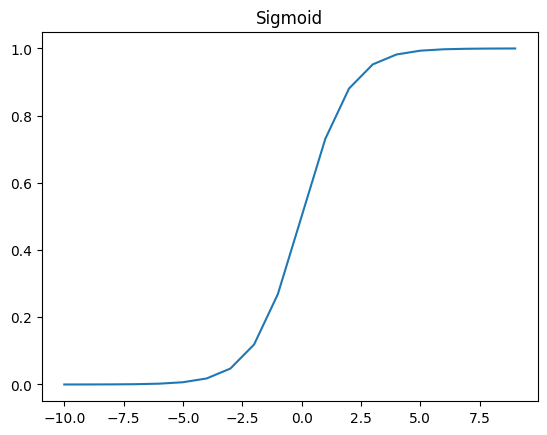

In [16]:
def sigmoid(x):
    """-> 0,1 = PROBABILTY"""
    return 1 / (1 + np.exp(-x))
plt.plot(np.arange(-10, 10), [sigmoid(x) for x in np.arange(-10, 10)])
plt.title('Sigmoid')

In [17]:
def softmax(x):
    """Compute softmax values for each sets of scores in x.

    -> 0,1 = PROBABILTY"""
    return np.exp(x) / np.sum(np.exp(X))

x = np.arange(-10, 10)

softmax(x)

array([6.29923701e-12, 1.71231015e-11, 4.65454157e-11, 1.26523558e-10,
       3.43926688e-10, 9.34889665e-10, 2.54129359e-09, 6.90795218e-09,
       1.87777609e-08, 5.10432462e-08, 1.38749929e-07, 3.77161410e-07,
       1.02523101e-06, 2.78686681e-06, 7.57548942e-06, 2.05923152e-05,
       5.59757163e-05, 1.52157772e-04, 4.13607708e-04, 1.12430232e-03])

In [18]:
model.compile(loss='categorical_crossentropy', optimizer='adam')


In [19]:
# exercise: look at different epoch numbers!

history = model.fit(X_train, Y_train, epochs=5)

Epoch 1/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 2.4440
Epoch 2/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.2843
Epoch 3/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.1593
Epoch 4/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.0357
Epoch 5/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.8782


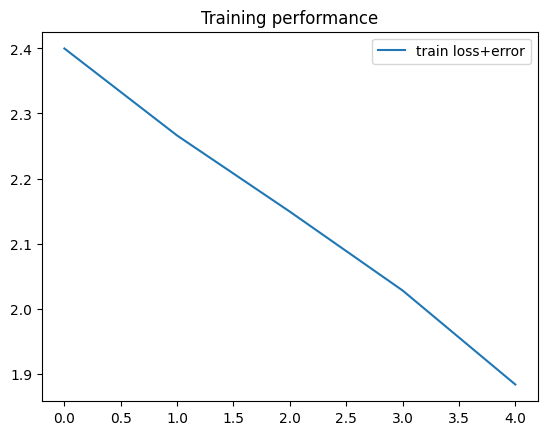

In [20]:
# Show loss curves
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.legend()

In [21]:
# Show simple version of performance

# X -> model -> Y
score = model.evaluate(X_test, Y_test)
score

172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4073


2.298769950866699

In [22]:
# train score (not a good metric)

score = model.evaluate(X_train, Y_train)
score

172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.6119


1.6264623403549194


## RNN Model
- Implement LSTM/GRU-based classifier  
- Capture temporal dependencies in I/Q signals  
- Train and evaluate similar to CNN  
- Compare strengths/weaknesses vs CNN  

---

## Hybrid CNN+RNN Model
- Combine convolutional feature extractor with RNN sequence modeling  
- Aim for best robustness across SNRs  
- Evaluate and compare with prior models  

---

## Results & Analysis
- Present accuracy table across models  
- Confusion matrices for each method  
- (Optional) Accuracy vs. SNR plot  
- Discuss performance trade-offs  

---

## Conclusion
- Summarize findings and best-performing model  
- Highlight limitations of dataset and methods  
- Suggest future extensions (e.g., transformers, larger datasets, real RF data)  

---

## References
- O’Shea et al., “RadioML Datasets,” DeepSig, 2016  
- Zhang et al., *IEEE Comm. Letters*, 2021  
- Guo et al., *IEEE IoT Journal*, 2024  
- Huynh-The et al., *IEEE Access*, 2021  